# Day 22 - The mechanics of learning

## A timeless lesson in modeling

## Learning is just parameter estimation

### A hot problem

* Our example will be a thermometer without units, which we want to understand

### Gathering some data

* For a couple of weeks, we gather unitless measurements from our new thermometer in unison with measurements in $°C$ from a different thermometer

In [1]:
import torch

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

### Visualizing the data

* Let's look at a quick plot of this data

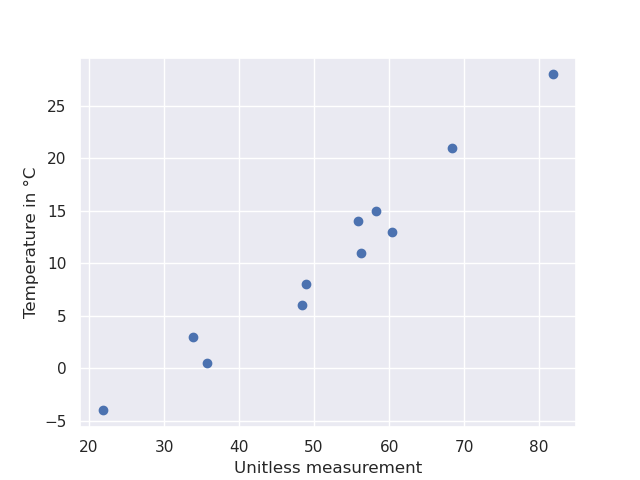

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots()
ax.scatter(t_u, t_c)
ax.set_xlabel("Unitless measurement")
ax.set_ylabel("Temperature in °C")
plt.show()

### Choosing a linear model as a first try

* Going with the simples plausible model first, this looks quite linear:

$$
t_c = w\times t_u+b
$$

* Our job is to find the model parameters $w$ and $b$, that fit the data best

## Less loss is what we want

* The loss function will tell us how bad our prediction is
* The simplest loss functions for this problem would be $|t_p - t_c|$, where $t_p$ is our prediction, and $t_c$ is the true temperature in °C, or $(t_p - t_c)^2$
* Both of these are great, because they are always positive when the prediction is wrong, and both are convex, with a minimum at zero
* The linearity of our model means that the loss is also convex as a function of our model parameters $w$ and $b$

### From problem back to PyTorch

In [3]:
def model(t_u, w, b):
    return w * t_u + b

In [4]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

In [5]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [6]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

## Down along the gradient

### Decreasing loss

* We can estimate the gradient by displacing $w$ by some small amount $\delta$ in each direction, and seeing how the loss changes over that interval $2\delta$

In [7]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) -
     loss_fn(model(t_u, w - delta, b), t_c)) / (2 * delta)

loss_rate_of_change_w

tensor(4517.2974)

* The change is positive, which tells us that increasing $w$ would increase our loss

In [8]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) -
     loss_fn(model(t_u, w, b - delta), t_c)) / (2 * delta)

loss_rate_of_change_b

tensor(82.5995)

* Here, we can see that the same applies to $b$
* Let us adjust our parameters after setting an appropriate $learning\ rate\ \alpha$

In [9]:
learning_rate = 1.5e-4

w -= learning_rate * loss_rate_of_change_w
b -= learning_rate * loss_rate_of_change_b

w, b

(tensor(0.3224), tensor(-0.0124))

In [10]:
t_p = model(t_u, w, b)

t_p

tensor([11.4975, 18.0101, 18.7516, 26.3926, 18.1390, 15.7532, 10.9172,  7.0160,
        15.5920, 19.4609, 22.0401])

* For fun, let us run this in a loop for a bit

In [11]:
num_steps = 100_000

w = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([1.0], requires_grad=True)

losses = torch.zeros(num_steps)

for i in range(1, num_steps + 1):
    t_p = model(t_u, w, b)
    loss = loss_fn(t_p, t_c)
    losses[i-1] = loss.detach()
    
    loss.backward()
    
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    w.grad.zero_()
    b.grad.zero_()
    
    if i % (num_steps / 10) == 0:
        print(f"Loss after step {i}: {loss:.4f}")

Loss after step 10000: 20.2560
Loss after step 20000: 13.1749
Loss after step 30000: 8.9875
Loss after step 40000: 6.5112
Loss after step 50000: 5.0468
Loss after step 60000: 4.1809
Loss after step 70000: 3.6688
Loss after step 80000: 3.3659
Loss after step 90000: 3.1868
Loss after step 100000: 3.0809


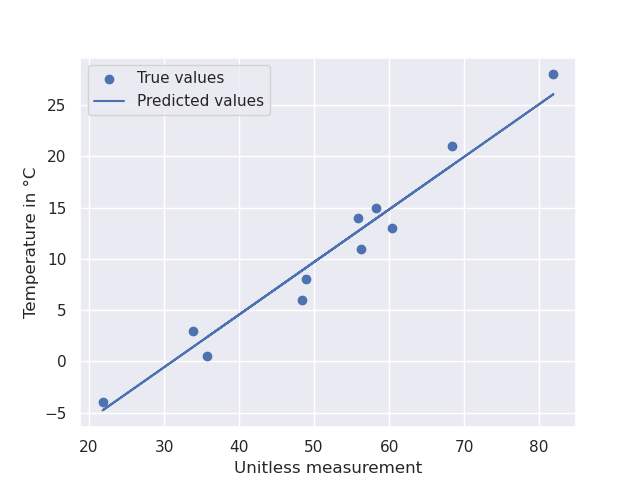

In [12]:
fig, ax = plt.subplots()

ax.scatter(t_u, t_c, label="True values")
ax.plot(t_u, t_p.detach(), label="Predicted values")
ax.set_xlabel("Unitless measurement")
ax.set_ylabel("Temperature in °C")
ax.legend()
plt.show()

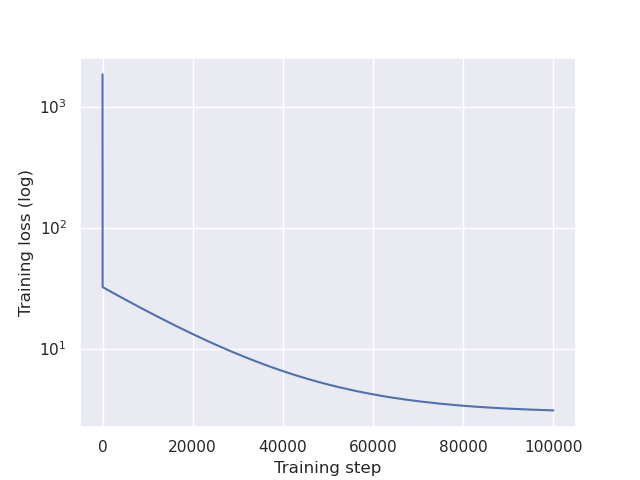

In [13]:
fig, ax = plt.subplots()

ax.plot(losses)
ax.set_xlabel("Training step")
ax.set_yscale("log")
ax.set_ylabel("Training loss (log)")
plt.show()

### Getting analytical

* Computing the gradient of the loss with respect to our model parameters manually like it is done above is of course too crude
* I used `loss.backward()` to do this automatically, which the book has not introduced yet
* Sorry about that
* Here is the chain rule, which is not properly rendered in the book:

$$
\frac{\partial\operatorname{loss}}{\partial w}=\frac{\partial\operatorname{loss}}{\partial t_p}\times\frac{\partial t_p}{\partial w}
$$
* The gradient then looks like this:

$$
\begin{align}
\nabla_{w,b}L&\doteq\left(\frac{\partial L}{\partial w}, \frac{\partial L}{\partial b}\right)^T \\
&=\left(\frac{\partial L}{\partial t_p}\cdot\frac{\partial t_p}{\partial w}, \frac{\partial L}{\partial t_p}\cdot\frac{\partial t_p}{\partial b}\right)^T
\end{align}
$$

### Iterating to fit the model

* We copy my training loop from above, and turn it into a nice function

In [14]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    # Keep track of the losses to return
    losses = torch.zeros(n_epochs)
    for i in range(1, n_epochs + 1):
        w, b = params
        # Run the current model
        t_p = model(t_u, w, b)
        # Calculate the loss from the latest predictions
        loss = loss_fn(t_p, t_c)
        # Store the loss for visualizing training progress later
        losses[i-1] = loss.item()

        # Adjust the model parameters
        loss.backward()
        with torch.no_grad():
            w -= learning_rate * w.grad
            b -= learning_rate * b.grad

        # Make sure to reset the gradients
        w.grad.zero_(), b.grad.zero_()
        
        if n_epochs < 10 or i % (n_epochs / 10) == 0:
            print(f"Loss after epoch {i}: {loss:.4f}")
    return w, b, losses

In [15]:
w = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([1.0], requires_grad=True)

w, b, losses = training_loop(num_steps, learning_rate, (w, b), t_u, t_c)

Loss after epoch 10000: 20.2560
Loss after epoch 20000: 13.1749
Loss after epoch 30000: 8.9875
Loss after epoch 40000: 6.5112
Loss after epoch 50000: 5.0468
Loss after epoch 60000: 4.1809
Loss after epoch 70000: 3.6688
Loss after epoch 80000: 3.3659
Loss after epoch 90000: 3.1868
Loss after epoch 100000: 3.0809


* In the book, training loss exploded, but we already addressed that problem above
* Let us illustrate this here as well, though

In [16]:
w = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([1.0], requires_grad=True)

w, b, losses = training_loop(100, 1e-2, (w, b), t_u, t_c)

Loss after epoch 10: 95118539121897135896908694349152256.0000
Loss after epoch 20: inf
Loss after epoch 30: nan
Loss after epoch 40: nan
Loss after epoch 50: nan
Loss after epoch 60: nan
Loss after epoch 70: nan
Loss after epoch 80: nan
Loss after epoch 90: nan
Loss after epoch 100: nan


* The loss blew up at a modest $\alpha=0.01$, which makes the need for normalization of our data clear

In [17]:
t_u_mean = t_u.mean()
t_u_std = t_u.std()

t_u_norm = (t_u - t_u_mean) / t_u_std

t_u_mean, t_u_std, t_u_norm

(tensor(51.8000),
 tensor(16.8319),
 tensor([-0.9565,  0.2436,  0.3802,  1.7883,  0.2673, -0.1723, -1.0635, -1.7823,
         -0.2020,  0.5109,  0.9862]))

In [18]:
w = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([1.0], requires_grad=True)

w, b, losses = training_loop(5, 0.5, (w, b), t_u_norm, t_c)

Loss after epoch 1: 151.8683
Loss after epoch 2: 3.4127
Loss after epoch 3: 2.9317
Loss after epoch 4: 2.9277
Loss after epoch 5: 2.9276


In [19]:
t_p = model(t_u_norm, w, b)

w_adjusted = w.detach() / t_u_std
b_adjusted = b.detach() - w.detach() * (t_u_mean / t_u_std)

print(f"w           =   {w_adjusted.item():.3f}\t(5/9 = {5/9:.3f})")
print(f"b * (9 / 5) = {b_adjusted.item() * 9 / 5:.2f}")

w           =   0.537	(5/9 = 0.556)
b * (9 / 5) = -31.15


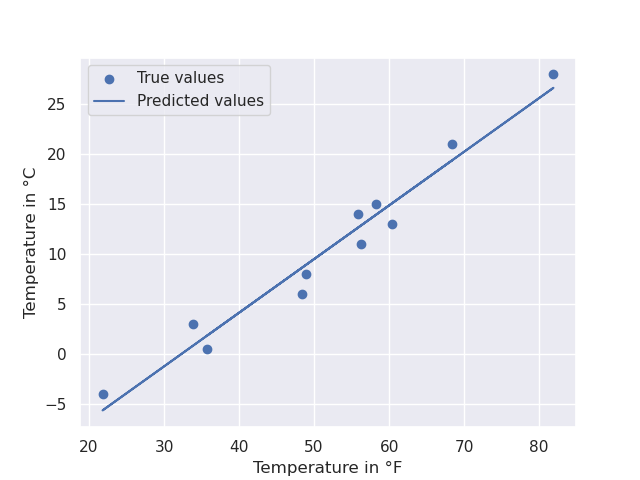

In [20]:
fig, ax = plt.subplots()

ax.scatter(t_u, t_c, label="True values")
ax.plot(t_u, t_p.detach(), label="Predicted values")
ax.set_xlabel("Temperature in °F")
ax.set_ylabel("Temperature in °C")
ax.legend()
plt.show()

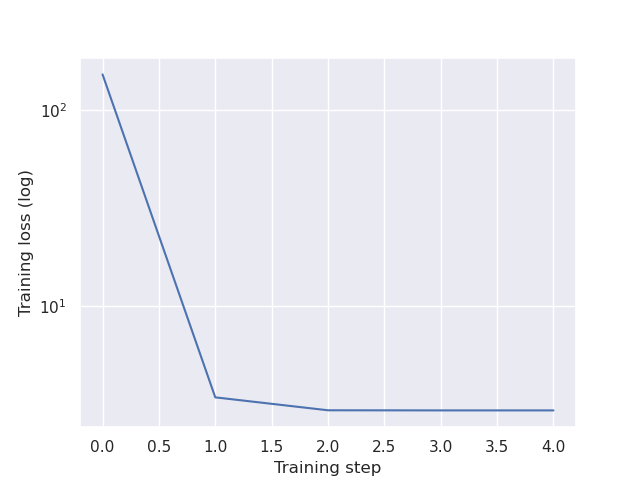

In [21]:
fig, ax = plt.subplots()

ax.plot(losses)
ax.set_xlabel("Training step")
ax.set_yscale("log")
ax.set_ylabel("Training loss (log)")
plt.show()

* The immense gains from normalization should be obvious, given that we have a better fit now, after three epochs, than we could previously get in $100,000$ epochs

### Normalizing inputs

* Oops, rushed ahead again
* See above

### Visualizing (again)

* Oops, rushed ahead again, *again*
* See above above

## PyTorch's autograd: Backpropagating all things

* I did this already
* It just keeps happening

### Computing the gradient automatically

* This is where PyTorch's autograd comes in and does `backward()` for us

In [22]:
def model(t_u, w, b):
    return w * t_u + b

In [23]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [24]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [25]:
params.grad is None

True

In [26]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

* When `requires_grad` is `True`, calling `backward` will continually accumulate the gradient for the tensor, unless it is `.zero_`ed out
* The simplest training loop with autograd looks like the following code

In [27]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()

        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()

        with torch.no_grad():
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

### Optimizers à la carte

* We can see which optimizers are available in PyTorch directly, inside `torch.optim`

In [28]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adafactor',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_adafactor',
 '_functional',
 'lr_scheduler',
 'swa_utils']

* Each optimizer takes a list of parameters as its first argument, which it can then always access to update, using their own `grad`s
* The interface they expose are the simple methods `zero_grad` and `step`

In [29]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [30]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

* We have to remember to `zero_grad`, if we want to run this in a loop 

In [31]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_u_norm, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.1461, 0.2100], requires_grad=True)

* We can update our training loop to make use of this

In [32]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
 
    return params

In [33]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)    

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,                           
    t_u = t_u_norm,
    t_c = t_c)

Epoch 500, Loss 2.927646
Epoch 1000, Loss 2.927645
Epoch 1500, Loss 2.927645
Epoch 2000, Loss 2.927645
Epoch 2500, Loss 2.927645
Epoch 3000, Loss 2.927645
Epoch 3500, Loss 2.927645
Epoch 4000, Loss 2.927645
Epoch 4500, Loss 2.927645
Epoch 5000, Loss 2.927645


tensor([ 9.0349, 10.5000], requires_grad=True)

* Let us use this opportunity to compare proper normalization with the method used in the book, where the values are simply multiplied by $0.1$

In [34]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)    

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,                           
    t_u = t_u * 0.1,
    t_c = t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

* Now, we can check out what Adam can do

In [35]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

print("Unnormalized")
training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params,
    t_u = t_u,
    t_c = t_c)

Unnormalized
Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

In [36]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

print("Normalized")
training_loop(
    n_epochs = 1000,
    optimizer = optimizer,
    params = params,
    t_u = t_u_norm,
    t_c = t_c)

Normalized
Epoch 500, Loss 2.927646
Epoch 1000, Loss 2.927646


tensor([ 9.0349, 10.5000], requires_grad=True)

### Training, validation, and overfitting

* The usual, nothing new here
* The practical side is important though
* We want to split our data into training and validation sets

In [37]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 1, 10,  5,  9,  3,  2,  0,  7,  8]), tensor([4, 6]))

In [38]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_u_norm = t_u_norm[train_indices]
val_t_u_norm = t_u_norm[val_indices]

* We can now monitor validation loss during training

In [39]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)    
        train_loss = loss_fn(train_t_p, train_t_c)
 
        val_t_p = model(val_t_u, *params)          
        val_loss = loss_fn(val_t_p, val_t_c)
 
        optimizer.zero_grad()
        train_loss.backward()    
        optimizer.step()
 
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
 
    return params

In [40]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_u_norm,
    val_t_u = val_t_u_norm,
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 195.4278, Validation loss 65.8507
Epoch 2, Training loss 187.2049, Validation loss 62.8411
Epoch 3, Training loss 179.3327, Validation loss 59.9685
Epoch 500, Training loss 2.5785, Validation loss 5.0162
Epoch 1000, Training loss 2.5785, Validation loss 5.0164
Epoch 1500, Training loss 2.5785, Validation loss 5.0164
Epoch 2000, Training loss 2.5785, Validation loss 5.0164
Epoch 2500, Training loss 2.5785, Validation loss 5.0164
Epoch 3000, Training loss 2.5785, Validation loss 5.0164


tensor([ 9.3524, 10.4505], requires_grad=True)

* The authors are scared
* I am not

In [41]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 0.5
optimizer = optim.SGD([params], lr=learning_rate)

params = training_loop(
    n_epochs = 5,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_u_norm,
    val_t_u = val_t_u_norm,
    train_t_c = train_t_c,
    val_t_c = val_t_c)

val_preds = model(val_t_u_norm, *params)
val_loss = loss_fn(val_preds, val_t_c)
val_loss

Epoch 1, Training loss 195.4278, Validation loss 65.8507
Epoch 2, Training loss 3.7509, Validation loss 7.3917
Epoch 3, Training loss 2.5856, Validation loss 4.9001


tensor(5.0165, grad_fn=<MeanBackward0>)

### Training set

* My guess is that this section was supposed to be called "Test set," as it talks about the test set
* The model can directly overfit its parameters to the training data
* The developer can overfit the hyperparameters on the validation data
* Thus, the test set was born
* The test set may only be used for the final evaluation, after model selection has concluded

### Autograd nits and switching it off

* When computing the validation loss, there is no need for autograd to build the computation graph
* It is more efficient to turn autograd off during these computations
* We can simply use the context manager method, `with torch.no_grad()` here

In [42]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
 
        with torch.no_grad():   
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False    

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
 
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
 
    return params

* There is a different context manager function, `set_grad_enabled`, so that we can use conditions

In [43]:
def calc_forward(t_u, t_c, params, is_train=True):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss

In [44]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_loss = calc_forward(train_t_u, train_t_c, params)
        val_loss = calc_forward(val_t_u, val_t_c, params, is_train=False)
 
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
 
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
 
    return params

## Exercise

1. Redefine the model to be $w_2\times t_u^2+w_1\times t_u+b$.
    1. What parts of the training loop, and so on, need to change to accommodate this redefinition?
    1. What parts are agnostic to swapping out the model?
    1. Is the resulting loss higher or lower after training?
    1. Is the actual result better or worse?

The training loop can remain unchanged, as can the loss function. The model needs to be adjusted to reflect the new calculation.

In [45]:
def model(t_u, w1, w2, b):
    return w1 * t_u + w2 * t_u ** 2 + b

In [46]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_loss = calc_forward(train_t_u, train_t_c, params)
        val_loss = calc_forward(val_t_u, val_t_c, params, is_train=False)

        t_losses.append(train_loss.item())
        v_losses.append(val_loss.item())
 
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
 
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
 
    return params

Epoch 1, Training loss 174.7247, Validation loss 61.1302
Epoch 2, Training loss 54.2512, Validation loss 15.3164
Epoch 3, Training loss 25.6134, Validation loss 9.4318

Final Training loss: 1.8298
Final Validation loss: 3.8216


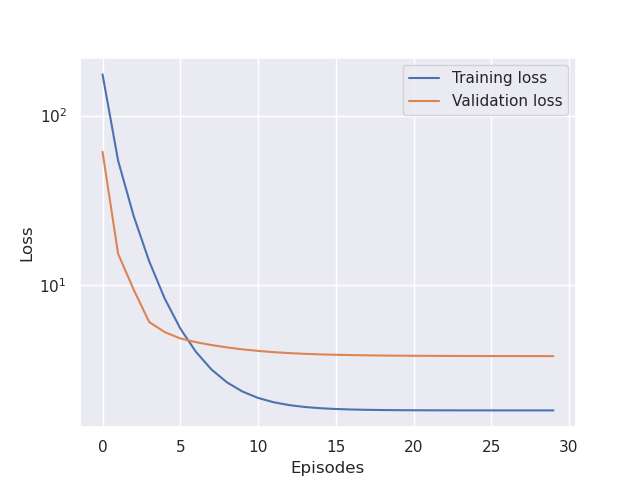

In [47]:
t_losses = []
v_losses = []

params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 0.2
optimizer = optim.SGD([params], lr=learning_rate)

params = training_loop(
    n_epochs = 30,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_u_norm,
    val_t_u = val_t_u_norm,
    train_t_c = train_t_c,
    val_t_c = val_t_c)

print(f"\nFinal Training loss: {calc_forward(train_t_u_norm, train_t_c, params):.4f}")
print(f"Final Validation loss: {calc_forward(val_t_u_norm, val_t_c, params):.4f}")

fig, ax = plt.subplots()
ax.plot(t_losses, label="Training loss")
ax.plot(v_losses, label="Validation loss")
ax.set_xlabel("Episodes")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.legend()
plt.show()

As expected, the increased model capacity allows the model to fit the training data better, at the expense of the validation loss. The quality of the model has gone down, tue to overfitting.